### 1.Import required packages  

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

### 2.Loading the data

In [2]:
Job_titles = pd.read_csv('Job titles and industries.csv')
Job_titles.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


## 3. Exploring the data


**3.1 data dimensions**

In [3]:
Job_titles.shape

(8586, 2)

**3.2 duplicates**

In [4]:
Job_titles.duplicated().sum()

4618

    Ooh, Almost half of the data is duplicated

**3.3 Exploring the target**

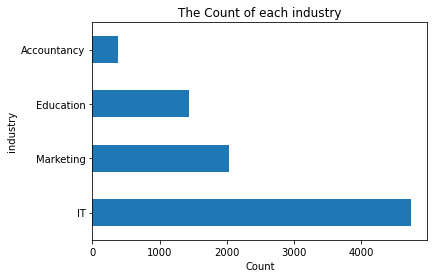

In [5]:
Job_titles['industry'].value_counts().plot.barh()
plt.ylabel('industry')
plt.xlabel('Count')
plt.title('The Count of each industry')
plt.show()

The data is imbalanced!, we have to deal with that.

**3.4 stop words**

    There are some words that do not affect the type of job, such as prepositions, pronouns and other words like 'and, or etc...' 

    these are called stop words, let's explore them in our data

In [6]:
stop_words = stopwords.words('english')

Job_titles['stopwords'] = Job_titles['job title'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
Job_titles[['job title','stopwords']].head()

,job title,stopwords
0,technical support and helpdesk supervisor - co...,1
1,senior technical support engineer,0
2,head of it services,2
3,js front end engineer,0
4,network and telephony controller,1


There are some stop words that need to be removed.

**Note**: in the third record, 'it' is considered as stop word because it's the same spelling as the pronoun 'it', but here it's an abbreviation for 'Informatoin Technology' and the presence of this word in the job title means that the job belongs to the IT industry, so we have not to omitted this word.

**3.5 numbers in the job title**

In [7]:
# checking for job titles that have numbers
Job_titles[Job_titles['job title'].str.contains('[0-9]')].head()

,job title,industry,stopwords
0,technical support and helpdesk supervisor - co...,IT,1
6,devops engineers x 3 - global brand,IT,0
7,devops engineers x 3 - global brand,IT,0
9,"php web developer £45,000 based in london",IT,1
10,devops engineers x 3 - global brand,IT,0


I think numbers don't affect here, so we need to remove them.

**3.6 special words**

In [8]:
# checking for special characters
Job_titles[Job_titles['job title'].str.contains('[$@#%&\(\)]')].head()

,job title,industry,stopwords
20,"c# software developer, waltham cross, £55k",IT,0
47,"front end javascript developer (react.js), £55...",IT,0
66,head of data & analytics,IT,1
98,software developer - c# .net javascript,IT,0
149,experienced web & systems developer,IT,0


These special characters should be removed, because they will be considered as a feature and they may be mislead the model as they do not affect the type of industry

**3.7 most commen words**

In [9]:
# Listing the most comment ten words
pd.Series(' '.join(Job_titles['job title']).split()).value_counts()[:10]

-            2100
developer    1411
engineer     1039
manager       901
marketing     881
senior        713
analyst       678
support       649
it            588
software      587
dtype: int64

Note the first one is '-' this is a special character and should be removed. 

## 4. data preprocessing

**4.1 encoding the industry column**

In [10]:
industry_mapping = {'IT':1, 'Marketing':2, 'Education':3, 'Accountancy':4}
Job_titles['industry'] = Job_titles['industry'].map(industry_mapping)
Job_titles.head()

,job title,industry,stopwords
0,technical support and helpdesk supervisor - co...,1,1
1,senior technical support engineer,1,0
2,head of it services,1,2
3,js front end engineer,1,0
4,network and telephony controller,1,1


**4.2 drop duplicates**

In [11]:
Job_titles.drop_duplicates(inplace=True)
Job_titles.shape

(3968, 3)

### 4.3 cleaning job titles

**remember**: as mentioned above, the pronoun it is the same spelling as IT job so I'm not going to remove it.

In [12]:
# check if 'it' is in 'stop_words'
'it' in stop_words

True

In [13]:
# so it's exist in 'stop_words', let's remove it
stop_words.remove('it')
# check again if 'it' is in 'stop_words' 
'it' in stop_words

False

In [14]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'fe

Good let's now clean the data

In [15]:
def clean(text):
    """
        this function will take text as an parameter and perform some 
        cleaning process on it like:
            - remove all non alphabetic characters.
            - make all words in lowercase
            - remove stop words
        parameters
        ----------
        text: text data required to be clean
        
        returns
        ----------
        text: text after cleaning
    """
    
    # remove all non alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text)
    
    # make all words in lowercase and split the text in words list
    words = text.lower().split()
    
    # loop for every word in words and check if it isn't in 'stop_words', then add it to 'wanted_words' list
    wanted_words = []
    for word in words:
        if word not in stop_words:
            # there are job titles have salary in our data, like £55k after removeing the number and the 
            # special character £, there is only 'k', I want to remove this also.
            # so I will remove any word that have only one character
            if len(word) > 1:
                wanted_words.append(word)
            
    # join the words again to put them in a cleanes text.
    return ' '.join(wanted_words)

In [16]:
# testing clean function 
clean("front end javascript developer (react.js), £55k, 4 days remote, 1 day ascot")

'front end javascript developer react js days remote day ascot'

It seems to be working properly. let's apply it to the data.

In [17]:
Job_titles['clean job title'] = Job_titles['job title'].apply(clean)
Job_titles.head()

,job title,industry,stopwords,clean job title
0,technical support and helpdesk supervisor - co...,1,1,technical support helpdesk supervisor county b...
1,senior technical support engineer,1,0,senior technical support engineer
2,head of it services,1,2,head it services
3,js front end engineer,1,0,js front end engineer
4,network and telephony controller,1,1,network telephony controller


**4.4 Tokenization**

    it's the time to transform text('clean job title' column) into a meaningful representation of numbers which is used   to fit machine algorithm for prediction.

In [18]:
tf_idf = TfidfVectorizer()
X = tf_idf.fit_transform(Job_titles['clean job title'])

# TfidfVectorizer produce a spars matrix, we need to convert it to array using .toarray() method
X = X.toarray()
print(X.shape)
X

(3968, 1877)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
y = Job_titles['industry']

## 5. Modeling

**5.1 split the data into train and test**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

**5.2 build a model** 

In [21]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

**5.3 evaluate the model**

In [22]:
print(f'Train score = {clf.score(X_train, y_train)}')
print(f'Test score = {clf.score(X_test, y_test)}')

Train score = 0.8995318689232985
Test score = 0.8606213266162889


    The accuracy score is pretty good. but wait, this is an imbalanced data so the accuracy score is not a good choice for evaluation here. let's use f1_score and see the confusion matrix.

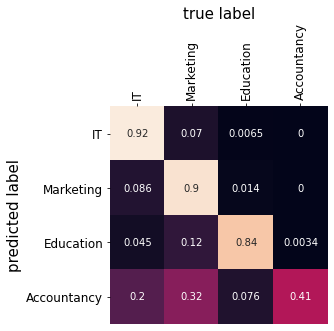

In [23]:
import seaborn as sns
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred, normalize='true')
industries = ['IT', 'Marketing', 'Education', 'Accountancy']

g = sns.heatmap(mat, square=True, annot=True, cbar=False, xticklabels=industries, yticklabels=industries)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_yticklabels(), rotation = 90, fontsize = 12)
g.xaxis.tick_top()
g.xaxis.set_label_position('top')
plt.xlabel('true label', fontsize = 15)
plt.ylabel('predicted label', fontsize = 15);

    As we expected, the model is very good at the majorty class but the accuracy decreasing in small classes
    look at Accountancy class, the model recognize only 0.41 of the data of this class.

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       459
           2       0.78      0.90      0.84       361
           3       0.95      0.84      0.89       292
           4       0.97      0.41      0.57        79

    accuracy                           0.86      1191
   macro avg       0.89      0.77      0.80      1191
weighted avg       0.87      0.86      0.86      1191



In [25]:
# f1_score for each class
f1_score(y_test, y_pred, average=None)

array([0.89925769, 0.83655084, 0.88727273, 0.57142857])

In [26]:
# f1_score overall
f1_score(y_test, clf.predict(X_test), average='weighted')

0.8555672748937718

### 6. Dealing with imbalanced data and try the model again

    There are many ways to deal with imbalanced data. here I will use a technique called SMOTE to make oversampling that would make the minority classes as the same length as the majority

In [27]:
pd.Series(y).value_counts()

1    1529
2    1203
3     973
4     263
Name: industry, dtype: int64

In [28]:
from imblearn.over_sampling import SMOTE

if I let the hyperparameter `sampling_strategy` with its default value, it will generate instances in each class that make it with the same number of the majority class. but I want the number of instances each class to be just close to each other.
it's not necessary to be the same number of instances. I only try to avoid generating many instances which might make the model overfit the data.

In [61]:
oversample = SMOTE(sampling_strategy={1:1529, 2:1500, 3:1300, 4:1000}, random_state=0)
X_smote, y_smote = oversample.fit_resample(X, y)

In [62]:
pd.Series(y_smote).value_counts()

1    1529
2    1500
3    1300
4    1000
Name: industry, dtype: int64

In [63]:
X_smote.shape, y_smote.shape

((5329, 1877), (5329,))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state=42, stratify=y_smote)

**5.2 build a model** 

In [65]:
clf_smote = MultinomialNB()
clf_smote.fit(X_train, y_train)

MultinomialNB()

**5.3 evaluate the model**

In [66]:
print(f'Train score = {clf_smote.score(X_train, y_train)}')
print(f'Test score = {clf_smote.score(X_test, y_test)}')

Train score = 0.9276139410187667
Test score = 0.9093183239524703


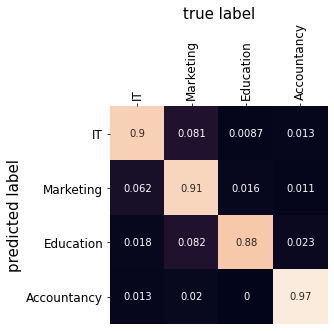

In [67]:
y_pred = clf_smote.predict(X_test)
mat = confusion_matrix(y_test, y_pred, normalize='true')
industries = ['IT', 'Marketing', 'Education', 'Accountancy']

g = sns.heatmap(mat, square=True, annot=True, cbar=False, xticklabels=industries, yticklabels=industries)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_yticklabels(), rotation = 90, fontsize = 12)
g.xaxis.tick_top()
g.xaxis.set_label_position('top')
plt.xlabel('true label', fontsize = 15)
plt.ylabel('predicted label', fontsize = 15);

    We can see the difference now, almost all classes have a good accuracy

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.90      0.91       459
           2       0.85      0.91      0.88       450
           3       0.97      0.88      0.92       390
           4       0.94      0.97      0.95       300

    accuracy                           0.91      1599
   macro avg       0.92      0.91      0.91      1599
weighted avg       0.91      0.91      0.91      1599



In [69]:
# f1_score for each class
f1_score(y_test, y_pred, average=None)

array([0.90549451, 0.87700535, 0.92059219, 0.95081967])

In [70]:
# f1_score overall
f1_score(y_test, y_pred, average='weighted')

0.9096630654558466

As we saw, accuracy is deceptive with the imbalanced data. so we have to use another metric like: f1_score, precision or recall.



finally, I will wrap up all this in a class in a python file and then build the API to use this class. see `IndustryClassification.py` and `API.py` files

### references:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/<br>
https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote<br>
https://www.upgrad.com/blog/multinomial-naive-bayes-explained/<br>
https://towardsdatascience.com/creating-restful-apis-using-flask-and-python-655bad51b24<br>
https://youtube.com/watch?v=UbCWoMf80PY&feature=share<br>